# 모델1 : 전복

## 모델구성
- 레거시모델과 가장 유사하게 모델 구성
- 성별 원핫인코딩
- 은닉층2개
- 노드개수 = 특성 수(10개)

## 가설 : 은닉층의 노드가 늘어나면 성능이 오를 것
- 은닉층은 16개로 고정
- 은닉층의 노드 수를 2의 지수(2,4,8,16...)로 늘려가며 평가점수 비교

## 결과
- 노드수가 늘어나도 성능이 오르지 않음
- loss : 4.8~5.0 / accuracy : 0.75~0.78
- 오히려 노드수 128개 이상은 학습이 잘 되지 않음

In [17]:
# Tensorflow Check
import tensorflow as tf
from tensorflow.python.client import device_lib
import sys
print(f'Python     : {sys.version.split("|")[0]}')
print(f'Tensorflow : {tf.__version__}')
print(f'TF GPU     : {"True" if device_lib.list_local_devices()[1] else "False"}')

Python     : 3.10.11 
Tensorflow : 2.10.1
TF GPU     : True


In [18]:
# 필요한 라이브러리 불러오기
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tensorflow import keras
from IPython.display import clear_output
import json

# 각종 변수 선언
csv_path = 'D:/coding/aib/GPTeachersDay/TeamProject1/leeyeonjun/Data/Regression_data.csv'
EPOCHS = 1000
MB_SIZE = 1024

In [19]:
# 필요한 함수 / 메소드 정의
class EvalAccuracy(tf.keras.metrics.Metric):
    """
    사용자 정의 평가지표 : Accuracy
    """
    def __init__(self, name="accuracy", **kwargs):
        super(EvalAccuracy, self).__init__(name=name, **kwargs)
        self.correct = self.add_weight(name=name, initializer="zeros")

    def update_state(self, y_true, y_predict, sample_weight=None):
        value = tf.abs((y_predict - y_true) / y_true)
        self.correct.assign(tf.reduce_mean(value))

    def result(self):
        return 1 - self.correct

    def reset_state(self):
        self.correct.assign(0.)

class CustomCallback(keras.callbacks.Callback):
    """
    사용자 정의 콜백함수
    """
    def on_train_begin(self, logs=None):
        print("Starting training")

    def on_train_end(self, logs=None):
        print("End training")
        clear_output(wait=True)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 100 == 0:print()
        if epoch % 10 == 0:
            print(f'{epoch} / ', end='')

def load_data(csv_path, TRAIN_RATIO=0.8):
    global X, y, X_train, X_test, y_train, y_test, df
    
    # 데이터셋 로드
    df = pd.read_csv(csv_path)
    
    # 성별 원핫 인코딩
    df=pd.get_dummies(df,columns=['Sex'])
    
    # 학습 데이터 분리
    X = df.drop('Rings', axis=1)
    y = df['Rings'].astype('float32')
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_RATIO, random_state = 83)
    
    return df, X, y, X_train, X_test, y_train, y_test

def get_model(shape, layer_n=15, node_n=4):
    inputs  = keras.Input(shape=shape)
    
    x = keras.layers.Dense(node_n)(inputs)
    for _ in range(layer_n):
        x = keras.layers.Dense(node_n)(x)
    
    outputs = keras.layers.Dense(1)(x)
    model   = keras.Model(inputs, outputs, name='Abalone_Model')
    
    model.compile(
        optimizer=keras.optimizers.Adam(0.01),
        loss=keras.losses.MeanSquaredError(),
        metrics=[EvalAccuracy()]
        )
    return model

In [20]:
df, X, y, X_train, X_test, y_train, y_test = load_data(csv_path)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_train.describe()

(3341, 10) (836, 10) (3341,) (836,)


,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Sex_F,Sex_I,Sex_M
count,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000,3341.000000
mean,0.523174,0.407287,0.139611,0.825669,0.357513,0.180396,0.237986,0.314576,0.317869,0.367555
std,0.119784,0.099014,0.042640,0.488083,0.221129,0.109401,0.138090,0.464416,0.465718,0.482211
min,0.110000,0.090000,0.000000,0.008000,0.002500,0.000500,0.003000,0.000000,0.000000,0.000000
25%,0.450000,0.345000,0.115000,0.441000,0.185000,0.092000,0.130000,0.000000,0.000000,0.000000
50%,0.545000,0.425000,0.140000,0.799500,0.334000,0.171500,0.235000,0.000000,0.000000,0.000000
75%,0.615000,0.480000,0.165000,1.146000,0.498500,0.252500,0.325000,1.000000,1.000000,1.000000
max,0.815000,0.650000,1.130000,2.779500,1.488000,0.760000,1.005000,1.000000,1.000000,1.000000


In [23]:
# 은닉층 16개 고정, 노드 2~1024개까지 테스트
results = []
for i in range(1,11):
    print(f'은닉층 16개, 노드 {2**i}개 학습중...\n{results}')
    model = get_model(len(X_train.columns), node_n=2**i)
    
    # 얼리스타핑
    earlystop = keras.callbacks.EarlyStopping(monitor='val_accuracy'
                                            , min_delta=0.000001
                                            , patience=EPOCHS//5)

    # 모델 저장
    checkpoint_path = 'model1.h5'
    checkpoint = keras.callbacks.ModelCheckpoint(
                                            checkpoint_path
                                            , monitor='val_accuracy'
                                            , verbose=0
                                            , save_best_only=True
                                            , save_weights_only=True)

    # 모델 학습
    history = model.fit(X_train, y_train
                        , batch_size=MB_SIZE
                        , validation_split = 0.2
                        , verbose=0
                        , epochs=EPOCHS
                        , callbacks=[earlystop, checkpoint, CustomCallback()]
                        )
    
    # 가장 성능이 좋았던 모델을 가져와 평가하고 평가결과 리스트에 저장
    model.load_weights(checkpoint_path)
    loss, accuracy = model.evaluate(X_test, y_test)
    results.append((loss, accuracy))
results

27/27 [==============================] - 0s 4ms/step - loss: 1142350727619076985716736.0000 - accuracy: -128541442048.0000


[(4.825589179992676, 0.7773073315620422),
 (4.890598773956299, 0.7648411393165588),
 (5.184790134429932, 0.7822359800338745),
 (4.833505153656006, 0.7179156541824341),
 (4.805486679077148, 0.7549652457237244),
 (4.95699405670166, 0.7397558093070984),
 (947.3551635742188, -2.235596179962158),
 (119740240.0, -872.1857299804688),
 (436379850899456.0, -1705999.75),
 (1.142350727619077e+24, -128541442048.0)]

In [28]:
# 결과 pf으로 만들어 json으로 저장
results_df = pd.DataFrame(results, columns=['loss', 'accuracy'])
results_df['nodes'] = [2**x for x in range(1,11)]
results_df.to_json('model1_node1000.json')

In [ ]:
# json으로 저장된 결과 df으로 가져오기
with open('model1_node1000.json') as json_file:
    json_file = json.loads(json_file.read())
results_df = pd.DataFrame(json_file)
results_df

In [29]:
results_df

,loss,accuracy,nodes
0,4.825589e+00,7.773073e-01,2
1,4.890599e+00,7.648411e-01,4
2,5.184790e+00,7.822360e-01,8
3,4.833505e+00,7.179157e-01,16
4,4.805487e+00,7.549652e-01,32
5,4.956994e+00,7.397558e-01,64
6,9.473552e+02,-2.235596e+00,128
7,1.197402e+08,-8.721857e+02,256
8,4.363799e+14,-1.706000e+06,512
9,1.142351e+24,-1.285414e+11,1024


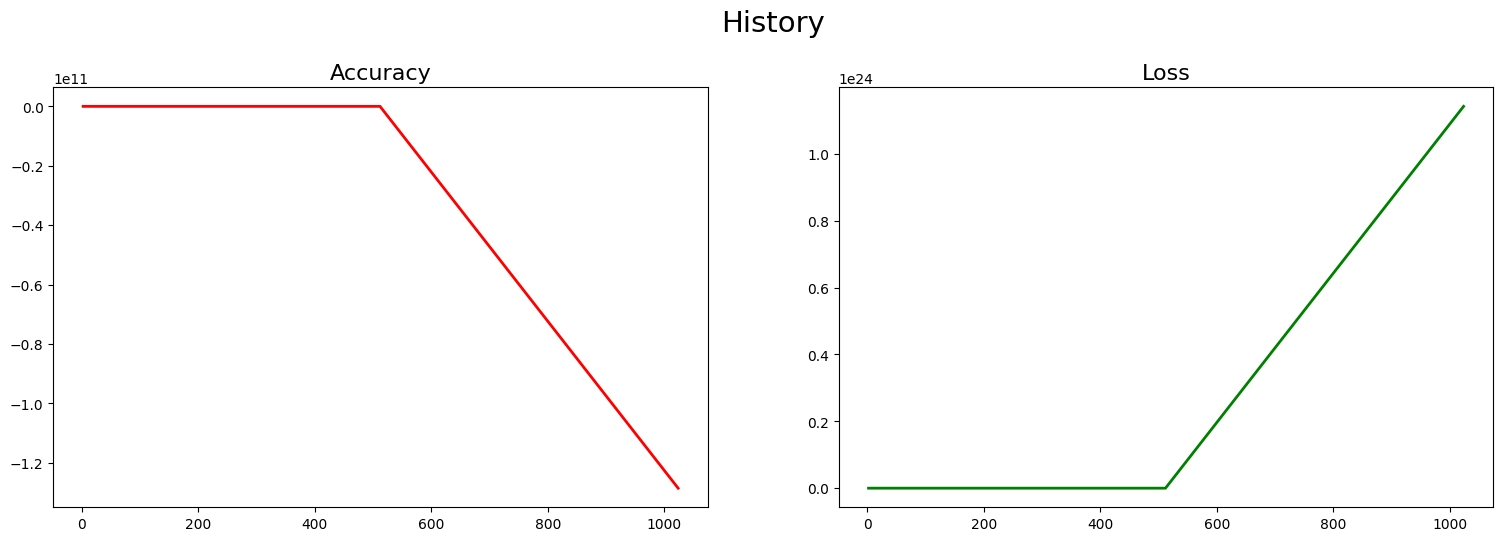

In [31]:
# 시각화
fig = plt.figure(figsize=(16, 6))
fig.suptitle('History', fontsize = 21)

# Accuracy Plot
ax = plt.subplot(1, 2, 1)
plt.title('Accuracy', fontsize = 16, y = 1)
plt.plot(results_df['nodes'], results_df['accuracy'], color='r', linewidth=2)

# Loss Plot
ax = plt.subplot(1, 2, 2)
plt.title('Loss', fontsize = 16, y = 1)
plt.plot(results_df['nodes'], results_df['loss'], color='g', linewidth=2)

plt.subplots_adjust(right=0.95, left=0.05, top=0.85, bottom=0.15, wspace=0.2, hspace=0.2)
plt.show()

fig.savefig('model1_node1000_history.png', dpi=80, bbox_inches='tight')